In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/3533495058.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/")
train_path = dataset_path / "train_5sec"

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    audio_files = []
    labels = []
    start_times = []
    end_times = []
    
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return pd.DataFrame()  # Return empty DataFrame if directory doesn't exist
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".mp3"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

    # Create DataFrame for the current directory
    data = {
        "file": audio_files,
        "start_time": start_times,
        "end_time": end_times,
        "A": labels
    }
    return pd.DataFrame(data)

# Initialize a dictionary to hold DataFrames for each training size
labels_trains = {}

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            training_size = train_size_dir.name  # Get the name of the training size directory

            # Process `pos` and `neg` subdirectories
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            df_pos = traverse_and_map(pos_dir, 1)  # 1 for "pos" files
            df_neg = traverse_and_map(neg_dir, 0)  # 0 for "negative" files

            # Combine the DataFrames for `pos` and `neg`
            combined_df = pd.concat([df_pos, df_neg], ignore_index=True)

            # Set MultiIndex with 'file', 'start_time', and 'end_time'
            combined_df.set_index(["file", "start_time", "end_time"], inplace=True)

            # Rename the only column to "A"
            combined_df.columns = ['A']

            # Store the DataFrame in the dictionary
            labels_trains[training_size] = combined_df

            # Optionally, save each DataFrame to a CSV file
            output_path = dataset_path / f"labels_trains_{training_size}.csv"
            combined_df.to_csv(output_path)
            print(f"DataFrame saved for training size {training_size}: {output_path}")
else:
    print(f"Train path does not exist: {train_path}")

# Display the DataFrames for verification
for training_size, df in labels_trains.items():
    print(f"\nDataFrame for training size {training_size}:")
    print(df.head())


DataFrame saved for training size train_size_150: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/labels_trains_train_size_150.csv
DataFrame saved for training size train_size_25: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/labels_trains_train_size_25.csv
DataFrame saved for training size train_size_175: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/labels_trains_train_size_175.csv
DataFrame saved for training size train_size_75: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/labels_trains_train_size_75.csv
DataFrame saved for training size train_size_100: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/labels_trains_train_size_100.csv
DataFrame saved for training size train_size_200: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/labels_trains_train_size_200.csv
DataFrame saved for training size train_size_50: /Users/yifeitao/Desktop/S

Processing data for training set

In [5]:
labels_trains['train_size_150'].head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_309_9sec_2_a.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_194_9sec_1_a.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_156_9sec_2_a.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_193_9sec_1_a.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_310_9sec_3_a.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_138_9sec_1_f.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_132_9sec_2_a.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_186_9sec_1_b.mp3,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/train_5sec/train_size_150/pos/t-11031961_179_9sec_1_b.mp3,0.0,5.0,1


Prepare audio Data

Step 1: Train shallow classifier on Perch embeddings

In [6]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


Step 2: Generate embeddings on the training and validation data

Training size 25

In [7]:
emb_train_25 = model.embed(labels_trains['train_size_25'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9996875 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [8]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/test_dataset_5sec.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/test_dataset_5sec.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 and row["Annotation"] == "COYOTE" else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 5 * 1000  # in milliseconds
    end_time = start_time + 5 * 1000  # 5 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    filename = row["filename"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(5.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

print(f"Processed dataset saved to {output_csv}")
print(f"Audio clips saved to {output_folder}")
print(df_processed.head())

Processed dataset saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/processed_test_dataset_5sec.csv
Audio clips saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/clips
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1


/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/240471425.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/test_dataset_5sec.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/240471425.py:39: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/clips/t-11031961_327_9sec_1_a.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/240471425.py:39: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/coyotes_5sec/test_5sec/clips/t-11031961_8_9sec_1_a.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/240471425.py:39: ResourceWarning: unclosed file <_io.B

In [9]:
labels_val = df_processed

In [10]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.987 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [11]:
emb_train_25 = torch.tensor(emb_train_25, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_25.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_25 = emb_train_25.view(emb_train_25.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_25: {emb_train_25.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([50, 512])
Reshaped emb_train_25: torch.Size([50, 1, 32, 16])
Reshaped emb_val: torch.Size([100, 1, 32, 16])


In [12]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [13]:
emb_train_25 = emb_train_25.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [14]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [15]:
quick_fit(model.network, emb_train_25, labels_trains['train_size_25'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 4.696367614087649e-05, Val Loss: 0.45042601227760315
val AU ROC: 0.870
val MAP: 0.870
Epoch 200/1000, Loss: 3.331392872496508e-05, Val Loss: 0.4591938257217407
val AU ROC: 0.871
val MAP: 0.871
Epoch 300/1000, Loss: 2.6388528567622416e-05, Val Loss: 0.4653064012527466
val AU ROC: 0.871
val MAP: 0.871
Epoch 400/1000, Loss: 2.146065526176244e-05, Val Loss: 0.4699302315711975
val AU ROC: 0.870
val MAP: 0.870
Epoch 500/1000, Loss: 1.785276981536299e-05, Val Loss: 0.47741538286209106
val AU ROC: 0.869
val MAP: 0.869
Epoch 600/1000, Loss: 1.5054414689075202e-05, Val Loss: 0.48703229427337646
val AU ROC: 0.870
val MAP: 0.870
Epoch 700/1000, Loss: 1.282439916394651e-05, Val Loss: 0.49523448944091797
val AU ROC: 0.869
val MAP: 0.869
Epoch 800/1000, Loss: 1.1113759683212265e-05, Val Loss: 0.5026193857192993
val AU ROC: 0.870
val MAP: 0.870
Epoch 900/1000, Loss: 9.67748201219365e-06, Val Loss: 0.5096595883369446
val AU ROC: 0.870
val MAP: 0.870
Epoch 1000/1000, Loss: 8.460397

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/1842857064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


0.9468000000000001

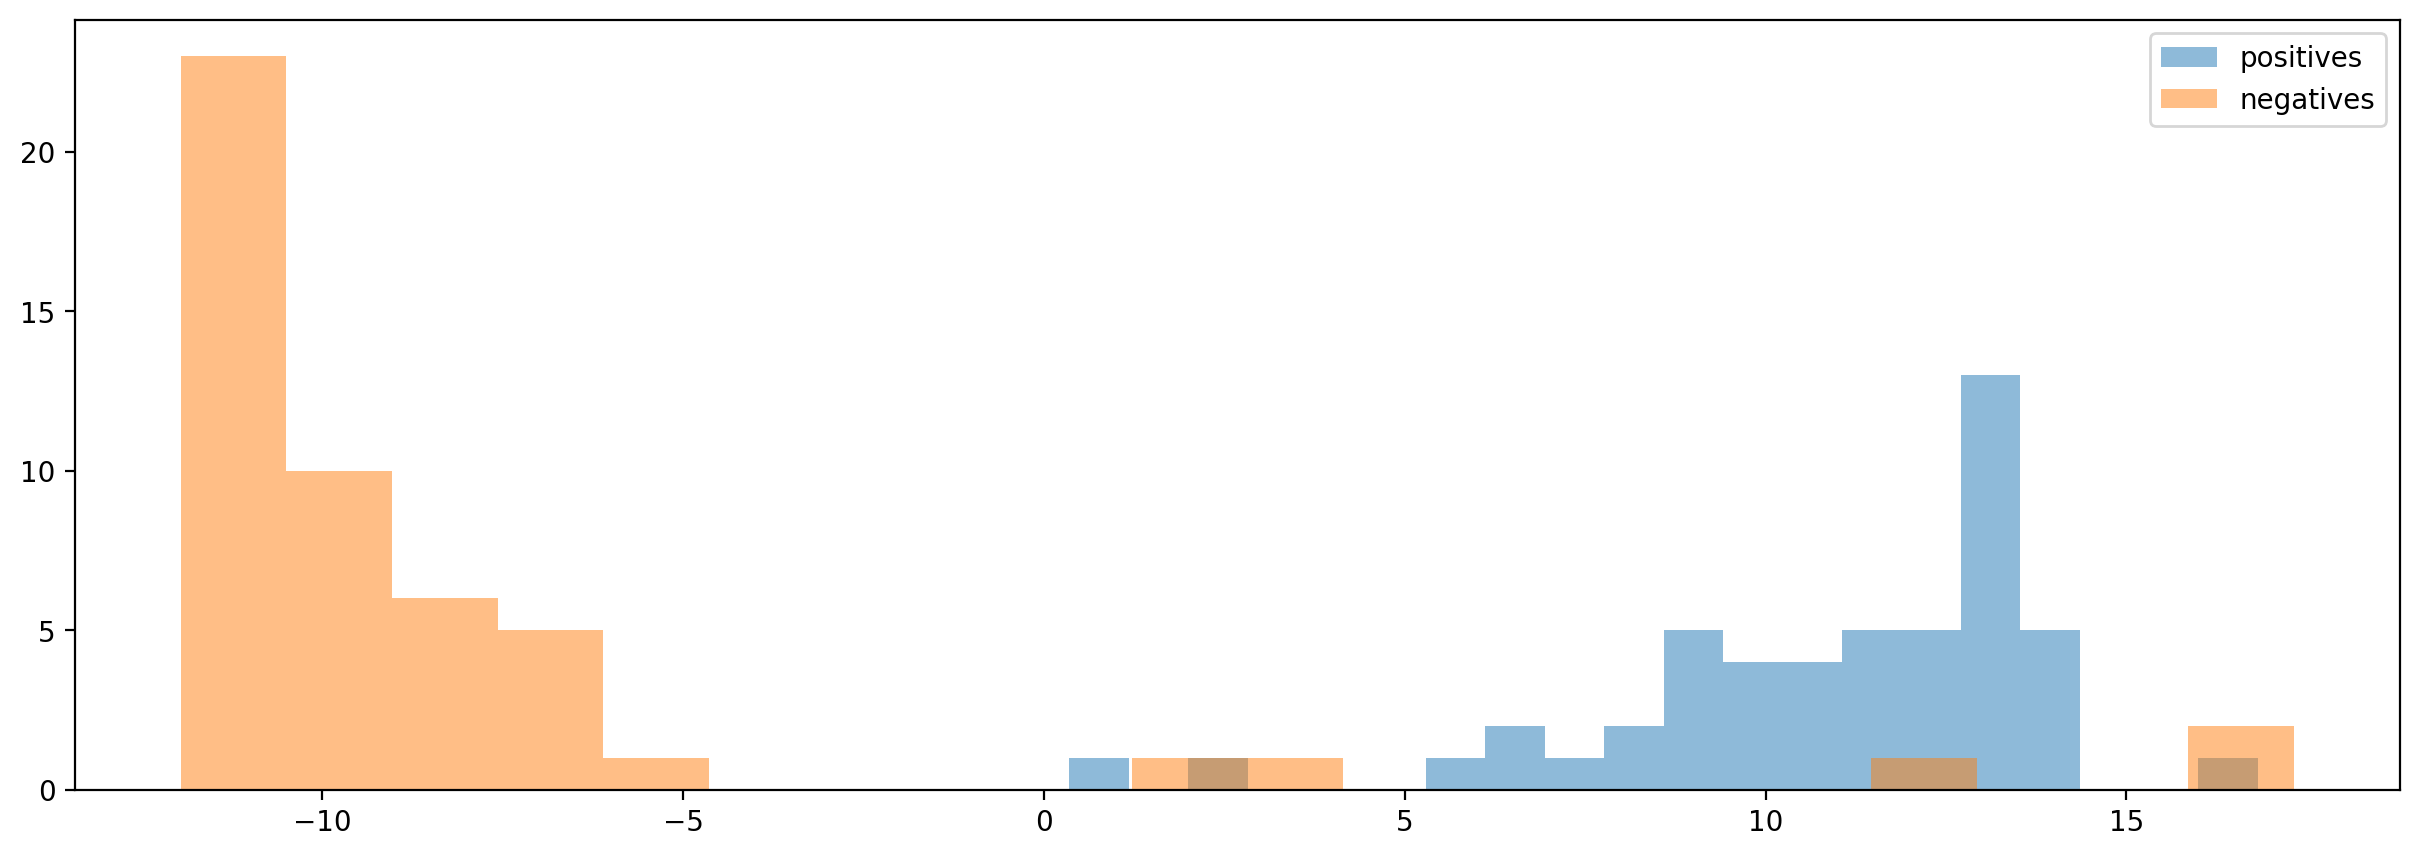

In [16]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_25 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_25

Training size 50

In [30]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [31]:
emb_train_50 = model.embed(labels_trains['train_size_50'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9996875 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999333333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [32]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.987 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [33]:
emb_train_50 = torch.tensor(emb_train_50, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_50.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_50 = emb_train_50.view(emb_train_50.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_50: {emb_train_50.shape}")

Original shape of emb_train: torch.Size([100, 512])
Reshaped emb_train_50: torch.Size([100, 1, 32, 16])


In [34]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [35]:
emb_train_50 = emb_train_50.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [36]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [37]:
quick_fit(model.network, emb_train_50, labels_trains['train_size_50'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 5.2010502258781344e-05, Val Loss: 0.31308507919311523
val AU ROC: 0.984
val MAP: 0.984
Epoch 200/1000, Loss: 3.131272387690842e-05, Val Loss: 0.31535109877586365
val AU ROC: 0.984
val MAP: 0.984
Epoch 300/1000, Loss: 2.1711925001000054e-05, Val Loss: 0.314022958278656
val AU ROC: 0.984
val MAP: 0.984
Epoch 400/1000, Loss: 1.595663525222335e-05, Val Loss: 0.3128301501274109
val AU ROC: 0.985
val MAP: 0.985
Epoch 500/1000, Loss: 1.1854160220536869e-05, Val Loss: 0.30786946415901184
val AU ROC: 0.985
val MAP: 0.985
Epoch 600/1000, Loss: 9.125097676587757e-06, Val Loss: 0.3089337646961212
val AU ROC: 0.983
val MAP: 0.983
Epoch 700/1000, Loss: 7.2658094723010436e-06, Val Loss: 0.3291058838367462
val AU ROC: 0.981
val MAP: 0.981
Epoch 800/1000, Loss: 5.942097232036758e-06, Val Loss: 0.34629926085472107
val AU ROC: 0.980
val MAP: 0.980
Epoch 900/1000, Loss: 4.926021119899815e-06, Val Loss: 0.3637412190437317
val AU ROC: 0.979
val MAP: 0.979
Epoch 1000/1000, Loss: 4.34912

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/2687331274.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.9808

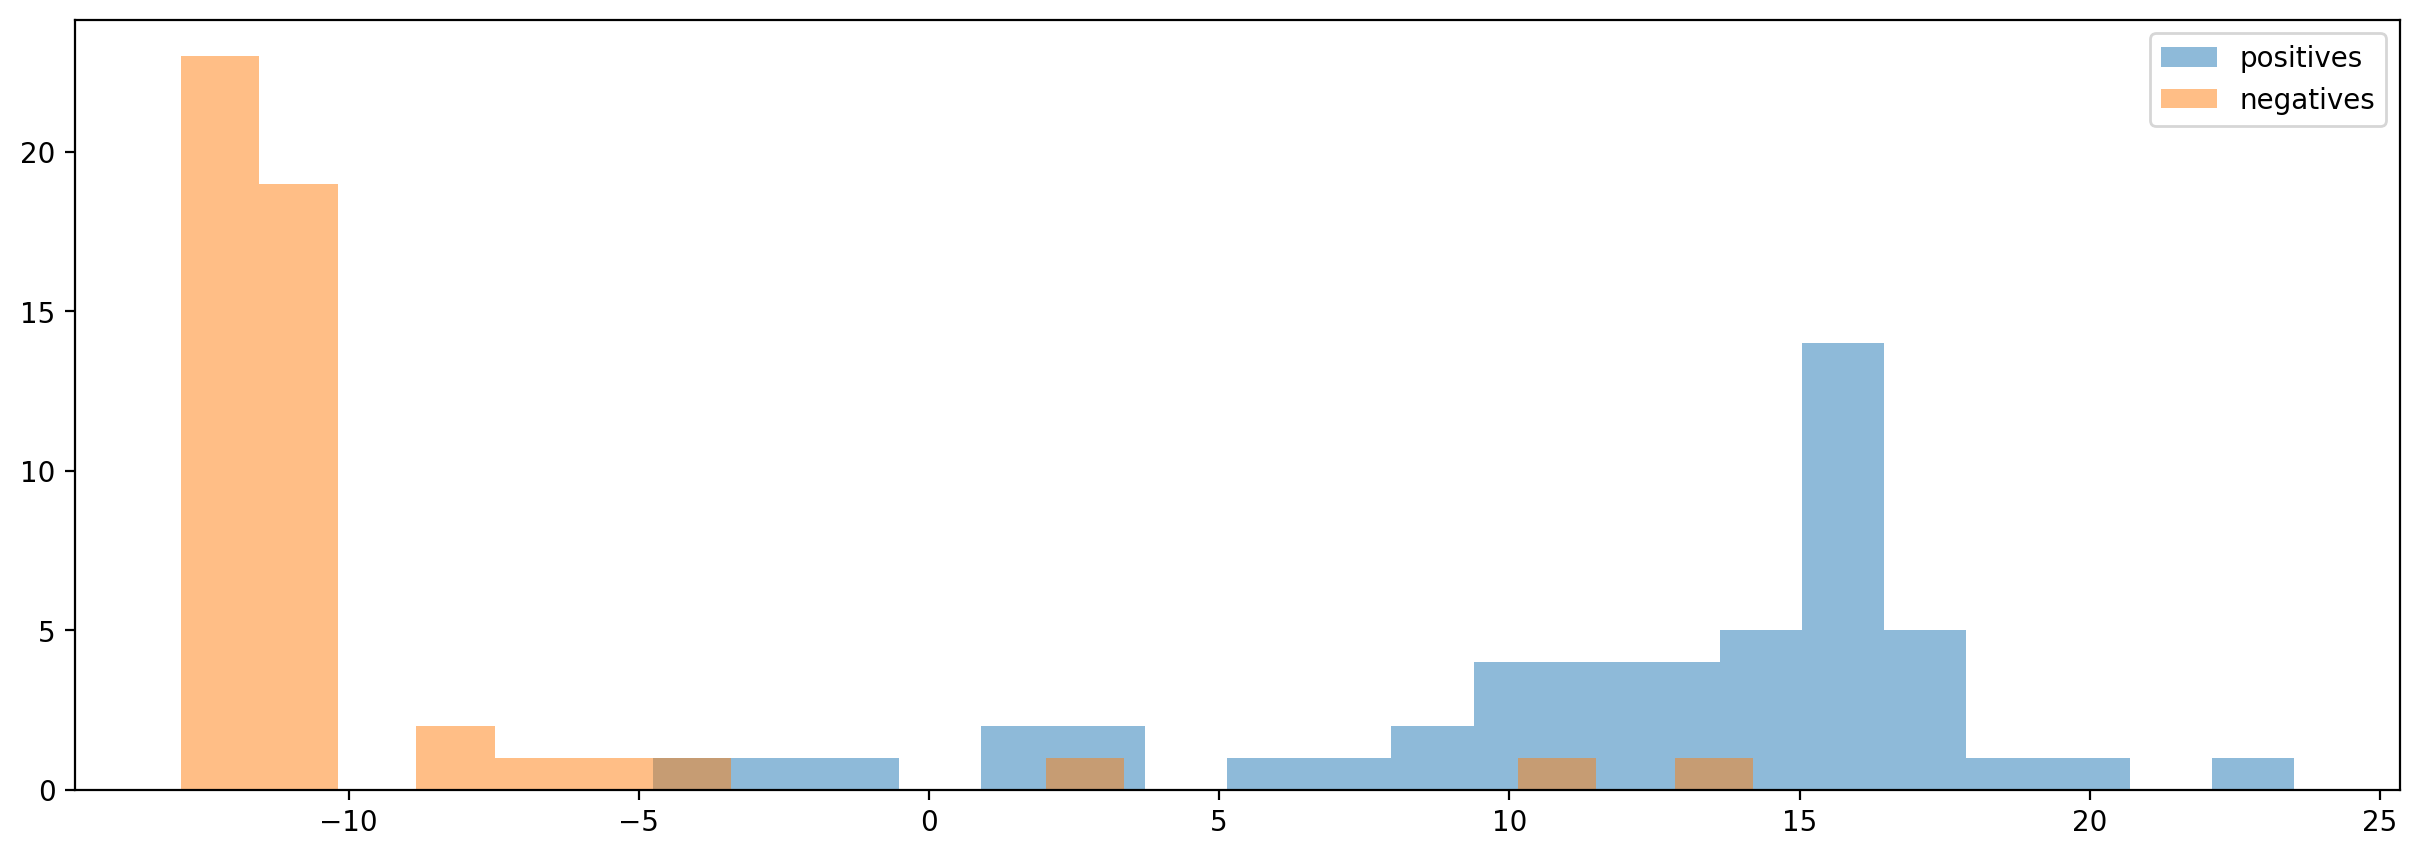

In [38]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_50 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_50

Training size 75

In [39]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [40]:
emb_train_75 = model.embed(labels_trains['train_size_75'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.9996875 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999770833333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999333333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999583333333334 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: Use

In [41]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.987 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [42]:
emb_train_75 = torch.tensor(emb_train_75, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_75.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_75 = emb_train_75.view(emb_train_75.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_75: {emb_train_75.shape}")

Original shape of emb_train: torch.Size([150, 512])
Reshaped emb_train_75: torch.Size([150, 1, 32, 16])


In [43]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [44]:
emb_train_75 = emb_train_75.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [45]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [46]:
quick_fit(model.network, emb_train_75, labels_trains['train_size_75'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 6.197774200700223e-05, Val Loss: 0.6496545672416687
val AU ROC: 0.922
val MAP: 0.922
Epoch 200/1000, Loss: 3.643999298219569e-05, Val Loss: 0.6411188244819641
val AU ROC: 0.923
val MAP: 0.923
Epoch 300/1000, Loss: 2.4466560716973618e-05, Val Loss: 0.6378747820854187
val AU ROC: 0.923
val MAP: 0.923
Epoch 400/1000, Loss: 1.7723566998029128e-05, Val Loss: 0.635617196559906
val AU ROC: 0.923
val MAP: 0.923
Epoch 500/1000, Loss: 1.3538875464291777e-05, Val Loss: 0.6344130635261536
val AU ROC: 0.923
val MAP: 0.923
Epoch 600/1000, Loss: 1.0697989637264982e-05, Val Loss: 0.6324711441993713
val AU ROC: 0.923
val MAP: 0.923
Epoch 700/1000, Loss: 8.699359568709042e-06, Val Loss: 0.6302506923675537
val AU ROC: 0.924
val MAP: 0.924
Epoch 800/1000, Loss: 7.233666110550985e-06, Val Loss: 0.62798672914505
val AU ROC: 0.924
val MAP: 0.924
Epoch 900/1000, Loss: 6.109575679147383e-06, Val Loss: 0.6232225298881531
val AU ROC: 0.924
val MAP: 0.924
Epoch 1000/1000, Loss: 5.22214986631

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_3947/3191350587.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


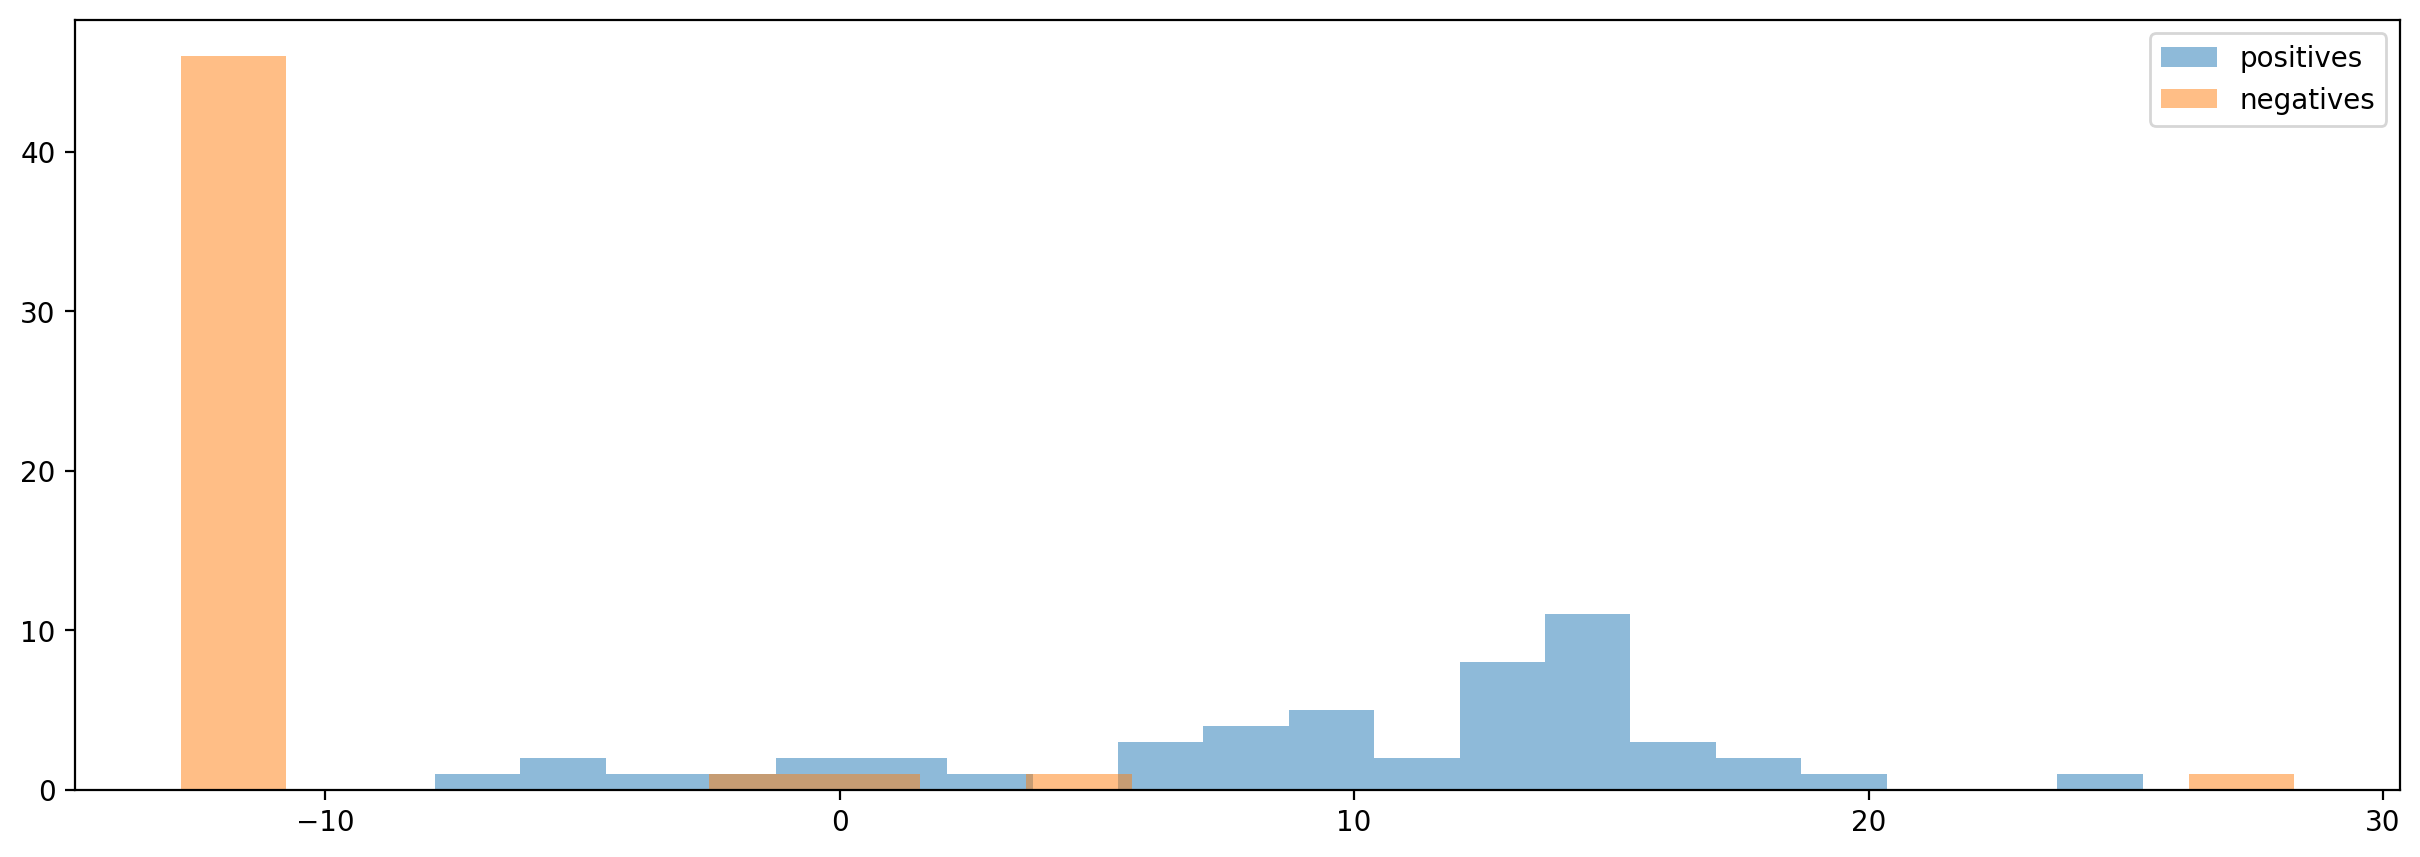

In [47]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_75 = roc_auc_score(labels_val.values,preds,average=None)

In [48]:
roc_auc_score_75

0.9716

Training size 100

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_train_100 = model.embed(labels_trains['train_size_100'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_100 = torch.tensor(emb_train_100, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_100.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_100 = emb_train_100.view(emb_train_100.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_100.shape}")

In [ ]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_100 = emb_train_100.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_100, labels_trains['train_size_100'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_100 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_100

Training size 125

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_train_125 = model.embed(labels_trains['train_size_125'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_125 = torch.tensor(emb_train_125, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_125.shape}")

height, width = 32, 16  # Ensure height * width = 512
emb_train_125 = emb_train_125.view(emb_train_125.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_125.shape}")

In [ ]:
emb_train_125 = emb_train_125.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
quick_fit(model.network, emb_train_125, labels_trains['train_size_125'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_125 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_125

Training size 150

In [ ]:
emb_train_150 = model.embed(labels_trains['train_size_150'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_150 = torch.tensor(emb_train_150, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_150.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_150 = emb_train_150.view(emb_train_150.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_150: {emb_train_150.shape}")

In [ ]:
emb_train_150 = emb_train_150.repeat(1, 3, 1, 1) 

In [ ]:
quick_fit(model.network, emb_train_150, labels_trains['train_size_150'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_150 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_150

Training size 175

In [ ]:
emb_train_175 = model.embed(labels_trains['train_size_175'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_175 = torch.tensor(emb_train_175, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_175.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_175 = emb_train_175.view(emb_train_175.shape[0], 1, height, width)


# Verify the reshaped embeddings
print(f"Reshaped emb_train_175: {emb_train_175.shape}")

In [ ]:
emb_train_175 = emb_train_175.repeat(1, 3, 1, 1) 

In [ ]:
quick_fit(model.network, emb_train_175, labels_trains['train_size_175'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_175 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_175

Training size 200

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_200 = model.embed(labels_trains['train_size_200'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_200 = torch.tensor(emb_train_200, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_200.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_200 = emb_train_200.view(emb_train_200.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_200: {emb_train_200.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_200 = emb_train_200.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_200, labels_trains['train_size_200'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_200 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_200

Training size 225

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_225 = model.embed(labels_trains['train_size_225'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_225 = torch.tensor(emb_train_225, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_225.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_225 = emb_train_225.view(emb_train_225.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_225: {emb_train_225.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_225 = emb_train_225.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_225, labels_trains['train_size_225'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_225 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_225

Training size 250

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_train_250 = model.embed(labels_trains['train_size_250'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_250 = torch.tensor(emb_train_250, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_250.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_250 = emb_train_250.view(emb_train_250.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_250: {emb_train_250.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_250 = emb_train_250.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_250, labels_trains['train_size_250'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_250 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_250

Training size 275

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_train_275 = model.embed(labels_trains['train_size_275'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_275 = torch.tensor(emb_train_275, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_275.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_275 = emb_train_275.view(emb_train_275.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_275: {emb_train_275.shape}")


In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_train_275 = emb_train_275.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_275, labels_trains['train_size_275'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_275 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_275

Training size 300

In [ ]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

In [ ]:
emb_train_300 = model.embed(labels_trains['train_size_300'], return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

In [ ]:
emb_train_300 = torch.tensor(emb_train_300, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_300.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_300 = emb_train_300.view(emb_train_300.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_300: {emb_train_300.shape}")


In [ ]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [ ]:
emb_val = emb_val.repeat(1, 3, 1, 1)
emb_train_300 = emb_train_300.repeat(1, 3, 1, 1) 

In [ ]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [ ]:
quick_fit(model.network, emb_train_300, labels_trains['train_size_300'].values, emb_val, labels_val.values, steps=1000)

In [ ]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_300 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_300

In [ ]:
training_sizes = []
roc_auc_scores = []

# Iterate over training sizes and collect the scores
for size in range(25, 301, 25):
    score = eval(f"roc_auc_score_{size}")
    training_sizes.append(size)
    roc_auc_scores.append(score)

# Create a DataFrame
df = pd.DataFrame({"Training Size": training_sizes, "ROC AUC Score": roc_auc_scores})


# Plot a line plot
plt.figure(figsize=(8, 5))
plt.plot(df["Training Size"], df["ROC AUC Score"], marker='o', linestyle='-')
plt.title("ROC AUC Score vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.show()